# 1. Install Dependencies and Setup

In [241]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\ragav\AppData\Local\Temp\pip-install-746iaz4n\tensorflow-gpu_7e87e4624ced4546a7940abfa32b7f47\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not buil

In [242]:
!pip list

Package                 Version
----------------------- -------
absl-py                 2.1.0
asttokens               2.4.1
colorama                0.4.6
comm                    0.2.1
debugpy                 1.8.1
decorator               5.1.1
dm-tree                 0.1.8
executing               2.0.1
grpcio                  1.60.1
h5py                    3.10.0
ipykernel               6.29.2
ipython                 8.21.0
jedi                    0.19.1
jupyter_client          8.6.0
jupyter_core            5.7.1
keras                   3.0.5
Markdown                3.5.2
markdown-it-py          3.0.0
MarkupSafe              2.1.5
matplotlib-inline       0.1.6
mdurl                   0.1.2
ml-dtypes               0.3.2
namex                   0.0.7
nest-asyncio            1.6.0
numpy                   1.26.4
packaging               23.2
parso                   0.8.3
pip                     24.0
platformdirs            4.2.0
prompt-toolkit          3.0.43
protobuf                4.25.3


In [243]:
import tensorflow as tf
import os

In [244]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [245]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [246]:
import cv2
import imghdr

In [247]:
data_dir = 'data' 

In [248]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [249]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [250]:
import numpy as np
from matplotlib import pyplot as plt

In [251]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 241 files belonging to 2 classes.


In [252]:
data_iterator = data.as_numpy_iterator()

In [253]:
batch = data_iterator.next()

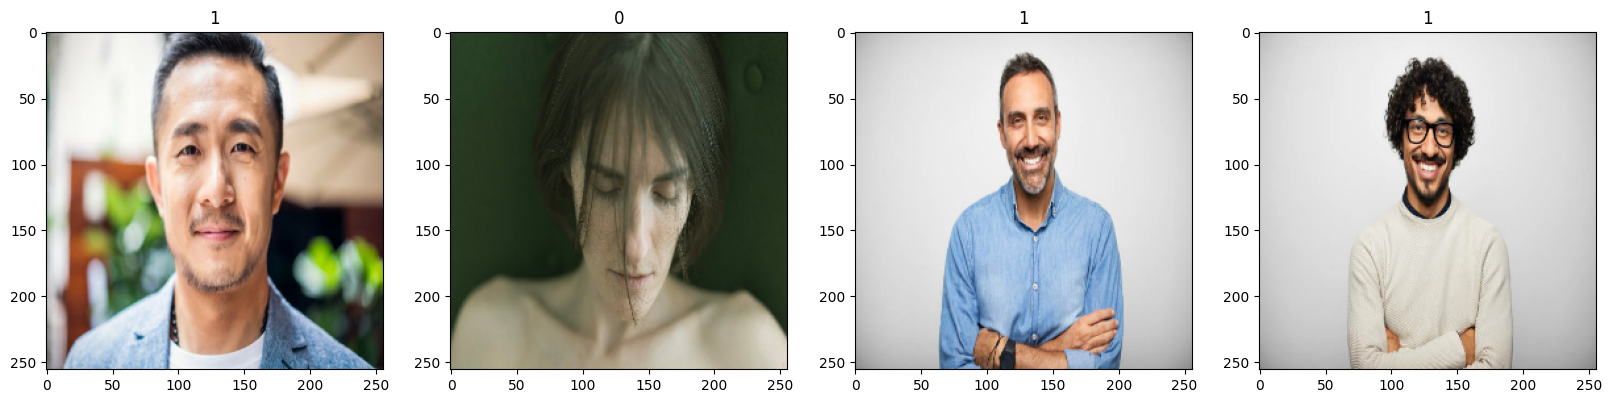

In [254]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [255]:
data = data.map(lambda x,y: (x/255, y))

In [256]:
data.as_numpy_iterator().next()

(array([[[[0.21568628, 0.28235295, 0.25882354],
          [0.21568628, 0.28235295, 0.25882354],
          [0.21568628, 0.28235295, 0.25882354],
          ...,
          [0.00784314, 0.0627451 , 0.06666667],
          [0.00784314, 0.0627451 , 0.06666667],
          [0.00392157, 0.05882353, 0.0627451 ]],
 
         [[0.21960784, 0.28627452, 0.2627451 ],
          [0.21960784, 0.28627452, 0.2627451 ],
          [0.21960784, 0.28627452, 0.2627451 ],
          ...,
          [0.00784314, 0.0627451 , 0.06666667],
          [0.00784314, 0.0627451 , 0.06666667],
          [0.00784314, 0.0627451 , 0.06666667]],
 
         [[0.22086397, 0.28753063, 0.26400122],
          [0.22086397, 0.28753063, 0.26400122],
          [0.22086397, 0.28753063, 0.26400122],
          ...,
          [0.00784314, 0.0627451 , 0.06666667],
          [0.00784314, 0.0627451 , 0.06666667],
          [0.00784314, 0.0627451 , 0.06666667]],
 
         ...,
 
         [[0.13333334, 0.13333334, 0.13333334],
          [0.13333

# 5. Split Data

In [257]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [258]:
train_size

5

In [259]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [260]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [261]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [262]:
model = Sequential()

In [263]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [264]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [265]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 30, 16)       

# 7. Train

In [266]:
logdir='logs'

In [267]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [268]:
hist = model.fit(train, epochs=11, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/11


5/5 [==============================] - 5s 656ms/step - loss: 1.1748 - accuracy: 0.4938 - val_loss: 0.9297 - val_accuracy: 0.3750
Epoch 2/11
5/5 [==============================] - 4s 587ms/step - loss: 0.7359 - accuracy: 0.4688 - val_loss: 0.6865 - val_accuracy: 0.5312
Epoch 3/11
5/5 [==============================] - 4s 585ms/step - loss: 0.6840 - accuracy: 0.5938 - val_loss: 0.6522 - val_accuracy: 0.8438
Epoch 4/11
5/5 [==============================] - 4s 579ms/step - loss: 0.6398 - accuracy: 0.7000 - val_loss: 0.5345 - val_accuracy: 0.8125
Epoch 5/11
5/5 [==============================] - 4s 561ms/step - loss: 0.5888 - accuracy: 0.6875 - val_loss: 0.5854 - val_accuracy: 0.7500
Epoch 6/11
5/5 [==============================] - 4s 579ms/step - loss: 0.5037 - accuracy: 0.7812 - val_loss: 0.5292 - val_accuracy: 0.6562
Epoch 7/11
5/5 [==============================] - 4s 616ms/step - loss: 0.4451 - accuracy: 0.7875 - val_loss: 0.2721 - val_accuracy: 0.9062
Epoch 8/11
5/5 [===============

# 8. Plot Performance

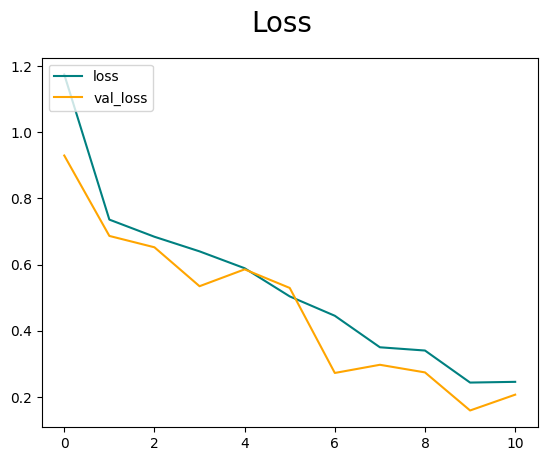

In [269]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

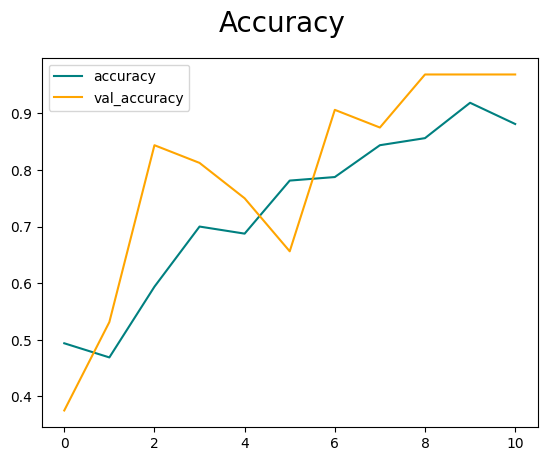

In [270]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [271]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [272]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [273]:
len(test)

0

In [274]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [275]:
print(f'Precision:{pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result()}')

Precision:0.0, Recall: 0.0, Accuracy: 0.0


In [276]:
#print(pre.result(), re.result(), acc.result())

# 10. Test

In [277]:
import cv2

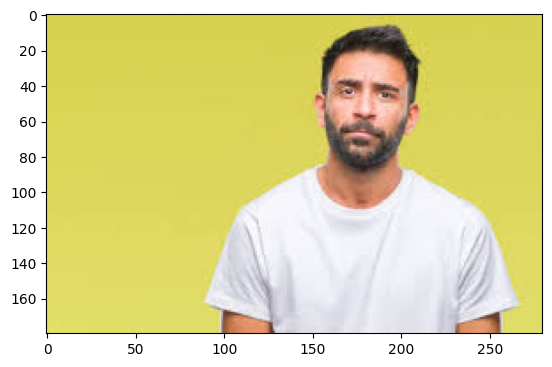

In [278]:
img = cv2.imread('images21.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

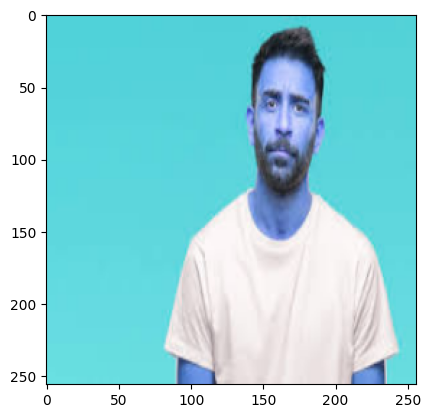

In [279]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [280]:
resize.shape

TensorShape([256, 256, 3])

In [281]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [282]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 92ms/step


In [283]:
yhat

array([[0.40803698]], dtype=float32)

In [284]:
if yhat > 0.5: 
    print(f'Predicted person is suicidal')
else:
    print(f'Predicted person is non-suicidal')
print(f'Training Accuracy: {hist.history["accuracy"][-1] * 100:.2f}%')
print(f'Validation Accuracy: {hist.history["val_accuracy"][-1] * 100:.2f}%')

Predicted class is non-suicidal
Validation Accuracy: 96.88%


# 11. Save the Model

In [285]:
from tensorflow.keras.models import load_model

In [286]:
import warnings
warnings.filterwarnings("ignore", message="You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.")


model.save(os.path.join('models','imageclassifier.h5'))

C:\Users\ragav\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [287]:
new_model = load_model('imageclassifier.h5')

In [288]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 65ms/step


array([[0.]], dtype=float32)